In [36]:
import sys, os, fnmatch, datetime, subprocess, imp
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
from itertools import islice

In [3]:
lib = pd.read_csv('/home/clara/Desktop/data/061318_exonskipping_library.csv', index_col=0, usecols = ('Identifier number', 'Designed 61-bp target site (37i-24e, AG)')).T.to_dict()

In [20]:
for root, subdirs, files in os.walk('.'):
    subdirs[:] = [d for d in subdirs if '.' not in d]
    for subdir in subdirs:
        print(subdir)
        for subroot, subsubdirs, subfiles in os.walk('/home/clara/Desktop/data/b6/'+subdir):
            if '.ipynb' not in subroot:
                subfiles[:] = [d for d in subfiles if d=='.ipynb_checkpoints']
                print(subfiles)
                print(subroot)

5
[]
/home/clara/Desktop/data/b6/5
12
[]
/home/clara/Desktop/data/b6/12
1
[]
/home/clara/Desktop/data/b6/1
6
[]
/home/clara/Desktop/data/b6/6
13
[]
/home/clara/Desktop/data/b6/13
7
[]
/home/clara/Desktop/data/b6/7
3
[]
/home/clara/Desktop/data/b6/3
0
[]
/home/clara/Desktop/data/b6/0
4
[]
/home/clara/Desktop/data/b6/4
10
[]
/home/clara/Desktop/data/b6/10
11
[]
/home/clara/Desktop/data/b6/11
9
[]
/home/clara/Desktop/data/b6/9
2
[]
/home/clara/Desktop/data/b6/2
14
[]
/home/clara/Desktop/data/b6/14
8
[]
/home/clara/Desktop/data/b6/8


In [ ]:
for root, subdirs, files in os.walk('.'):
    subdirs[:] = [d for d in subdirs if not d[0] == '.']
    for subdir in subdirs:
        if int(subdir) not in [5,12,1,6]:
            print(subdir)
            for subroot, subsubdirs, subfiles in os.walk('/home/clara/Desktop/data/b6/'+subdir):
                if '.ipynb' not in subroot:
                    result = pd.DataFrame(columns = ['umi','id', 'genotype'])
                    for file in subfiles:
                        result = result.append(read_file_fast(os.path.join(subroot, file)))
                    result.to_csv('new_result_'+subroot[28:]+'.csv', columns=('umi','id', 'genotype'),index=False)

13
7


In [253]:
def read_file_fast(txt):
    testdf = pd.DataFrame(columns = ['umi','id', 'genotype'])
    with open(txt) as file:
        while True:
            next_n_lines = list(islice(file, 8))
            if not next_n_lines or len(next_n_lines) != 8:
                break
                
            umi = next_n_lines[1].strip()
            ID = next_n_lines[2].strip()
            read_quality = next_n_lines[3].strip() 
            if float(read_quality) < 95.0:
                continue
                
            target_raw = next_n_lines[4].strip()
            target = re.sub(r'\W+', '', target_raw)
            skip2 = next_n_lines[5].strip()
            match = next_n_lines[6].strip()
            
            ag_loc = 36

            match_site = match[ag_loc-5:ag_loc+7]
            target_site = target_raw[ag_loc-5:ag_loc+7]

            if '-' in target_site and '-' not in match_site:
                testdf = testdf.append({'umi':umi, 'id':ID, 'genotype':'del'}, ignore_index=True)
            elif '-' in match_site and '-' not in target_site:
                testdf = testdf.append({'umi':umi, 'id':ID, 'genotype':'sub'}, ignore_index=True)
    return testdf

### Why are there some results that do not have an explicit splice site at the determined location (around 25-40 region of the read?)

In [ ]:
def read_file(txt, testdf):
    with open(txt) as file:
        for line in file:
            if line == '>1\n':
                umi = file.next().strip()
                ID = file.next().strip()

                if not testdf.loc[(testdf.umi == umi)&(testdf.id == ID)].empty:
                    continue

                skip = file.next()

                target_raw = file.next().strip()
                target = re.sub(r'\W+', '', target_raw)

                skip2 = file.next()

                match = file.next()
                
                if 'AG' in target[25:45]:
                    ag_loc = target.index('AG', 25, 45)
                    
                    match_site = match[ag_loc-10:ag_loc+12]
                    target_site = target[ag_loc-10:ag_loc+12]

                    if '-' in target_site and '-' not in match_site:
                        print('insertion')
                        testdf = testdf.append({'umi':umi, 'id':ID}, ignore_index=True)
                    elif '-' in match_site and '-' not in target_site:
                        testdf = testdf.append({'umi':umi, 'id':ID}, ignore_index=True)
                    elif '-' in target_site and '-' in match_site:
                        print(skip)
                    elif '.' in skip2[ag_loc-10:ag_loc+12]:
                        testdf = testdf.append({'umi':umi, 'id':ID}, ignore_index=True)
#                 else:
#                     print('LAKJSHDLKAJSDHLAKSJDHLKASJDH')
    return testdf

In [4]:
all_genotypes_df = pd.DataFrame(columns = ('umi','id')) 
for x in range(15):
    file = pd.read_csv('result_'+str(x)+'.csv')
    print(file.shape[0])
    all_genotypes_df = all_genotypes_df.append(file)

219368
219374
213008
216579
214905
18970
210718
211734
214930
220225
222971
222565
218836
208457
18183


In [203]:
all_genotypes_df.to_csv('b3_cas9.csv',index=False)

### What happens if there are two ids that both create mutant genotyps with one umi tag? - remove both 

### Should we do the 80% filtering for this as well? Or would it retain ttoo many mistake matches and therefore splice results --> only 100% in the code below, can modify later

this is wrong --> IDs are still incorrect at this step --> cannot filter for unique matches

In [5]:
# genotype_count = all_genotypes_df.groupby('umi')['id'].nunique().reset_index('umi').rename(columns = {'id':'id_count'})
# genotype_uniq_umi = genotype_count.loc[genotype_count.id_count==1]
# genotype_unique = all_genotypes_df[all_genotypes_df.umi.isin(genotype_uniq_umi['umi'])]

### What is the overlap between UMIs identified in b7 and the umis found via this method? 

In [18]:
b7 = pd.read_csv('/home/clara/Desktop/data/b7_complete.csv')
b7_dict = pd.Series(b7.id.values, index = b7.umi).to_dict()

all_genotypes_df['in_b7'] = all_genotypes_df.umi.apply(lambda x: True if x in b7_dict else False)
genotype_in_b7 = all_genotypes_df.loc[lambda x: x.in_b7 == True]

genotype_count = genotype_in_b7.groupby('umi')['id'].nunique().reset_index('umi').rename(columns = {'id':'id_count'})
genotype_uniq_umi = genotype_count.loc[genotype_count.id_count==1]
genotype_unique = genotype_in_b7[genotype_in_b7.umi.isin(genotype_uniq_umi['umi'])]

print(str(int((genotype_unique.shape[0])/float(genotype_in_b7.shape[0])*100))+'%')

51%


In [19]:
genotype_unique['b7_id'] = genotype_unique.umi.apply(lambda x: b7_dict[x])
genotype_unique['b3_target'] = genotype_unique.id.apply(lambda x: lib[x]['Designed 61-bp target site (37i-24e, AG)'])
genotype_unique['b7_target'] = genotype_unique.b7_id.apply(lambda x: lib[x]['Designed 61-bp target site (37i-24e, AG)'])
genotype_match = genotype_unique.loc[genotype_unique.b3_target == genotype_unique.b7_target]
genotype_non = genotype_unique.loc[genotype_unique.b3_target != genotype_unique.b7_target]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [20]:
geno_match = genotype_match.shape[0] 
geno_no = genotype_non.shape[0]
print(geno_match, geno_no)
print('around '+str(int(float(geno_match)/float(geno_match+geno_no)*100))+' percent')

(398833, 332712)
around 54 percent


### How much new information does this method provide with regards to b3 UMI and ID pairings? How about new splice results for b6?

In [21]:
b3_match = pd.read_csv('/home/clara/Desktop/data/b3_match.csv')
b3_dict = pd.Series(b3_match.id.values, index = b3_match.umi).to_dict()
genotype_match['b3_match'] = genotype_match.umi.apply(lambda x: True if x in b3_dict else False)
genotype_match.loc[lambda x: x.b3_match == True].shape[0]/float(genotype_match.shape[0]) # contains all umis in genotype but not b3 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.9725223339091801

In [10]:
b6_match = pd.read_csv('/home/clara/Desktop/data/b6_processed.csv')

In [22]:
genotype_dict = pd.Series(genotype_match.b7_id.values, index = genotype_match.umi).to_dict()

In [12]:
def remove_ggc(umi):
    return umi[:-3]

In [200]:
b6 = pd.read_csv('/home/clara/Desktop/data/b6.csv')

b6_nodups = b6.dropna()
b6_nodups.slice_type = b6_nodups.slice_type.apply(lambda x: x.strip())
b6_nodups = b6_nodups[~b6_nodups.umi.str.contains("N")]
b6_nodups.umi = b6_nodups.umi.apply(lambda x: remove_ggc(x))
b6_nodups['geno_umi'] = b6_nodups['umi'].apply(lambda x: True if x in genotype_dict else False)
b6_genotype_match = b6_nodups.loc[b6_nodups['geno_umi'] == True]

### Check how many unique Ids are represented --> how to do this for c and cryptic slices? by matching UMI

In [201]:
b6_genotype_match['real_id'] = b6_genotype_match.umi.apply(lambda x: genotype_dict[x])
b6_genotype_match.real_id.nunique()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


3581

In [25]:
b6_genotype_match.shape[0]

70848

In [202]:
b6_genotype_match = b6_genotype_match.drop('id', axis=1).rename(columns = {'real_id':'id'}).drop('geno_umi', axis=1)
b6_genotype_match.to_csv('b6_cas9_match.csv', index = False)

## Number of UMIs at each stage of processing - plots

In [16]:
b3 = pd.read_csv('/home/clara/Desktop/data/b3.csv')

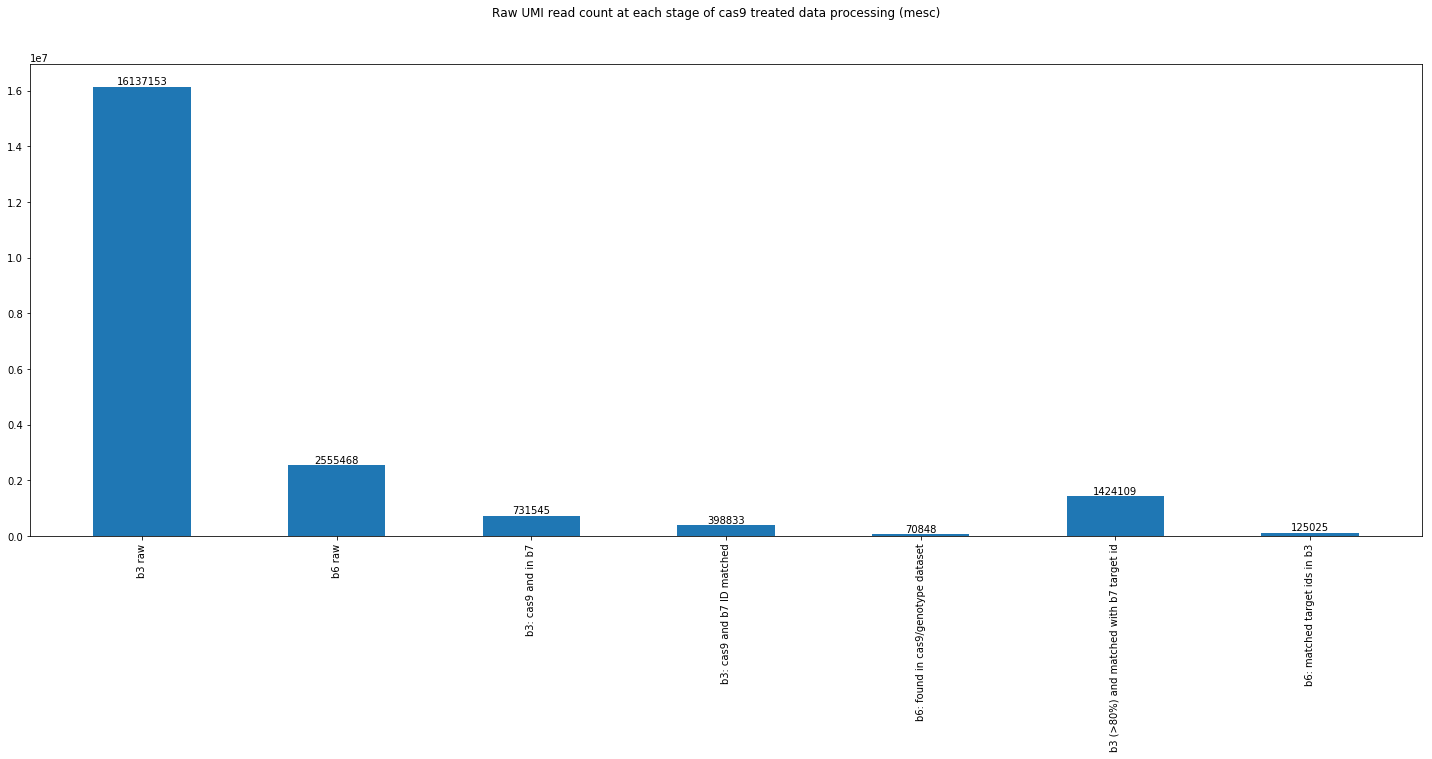

In [59]:
height = [b3.dropna().shape[0], b6.dropna().shape[0], genotype_unique.shape[0], genotype_match.shape[0], b6_genotype_match.shape[0], b3_match.shape[0], b6_match.shape[0]]
x = [1,2,3,4,5,6,7]
f = plt.figure()
f.set_size_inches(20,10)
f.suptitle('Raw UMI read count at each stage of cas9 treated data processing (mesc)', y = 1.05)
plot = plt.bar(x, height, width=0.5)
plt.xticks([1,2,3,4,5,6,7], ['b3 raw', 'b6 raw', 'b3: cas9 and in b7','b3: cas9 and b7 ID matched',
               'b6: found in cas9/genotype dataset',
               'b3 (>80%) and matched with b7 target id',
               'b6: matched target ids in b3'], rotation = 90)

rects = plot.patches

for rect, label in zip(rects, height):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.tight_layout()

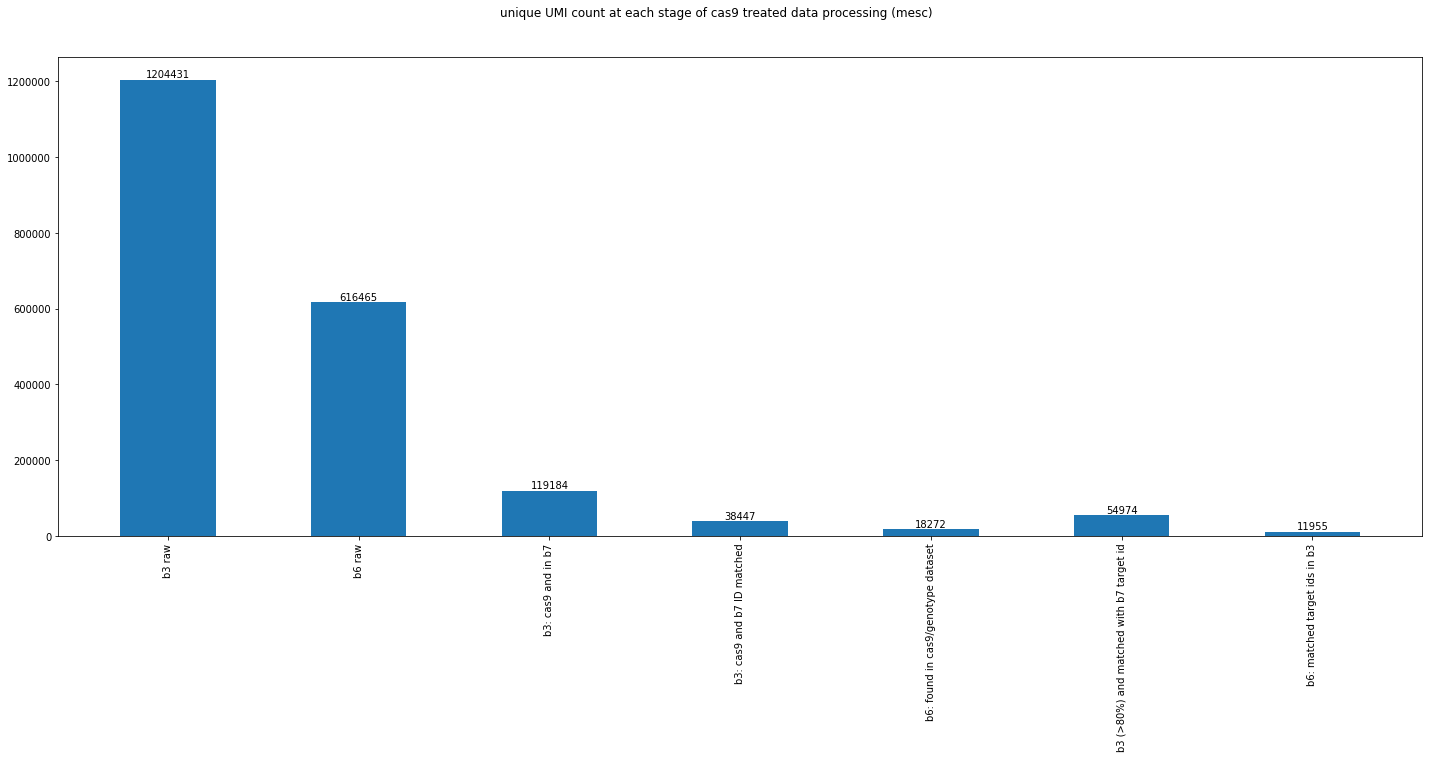

In [67]:
data = [b3.dropna(), b6.dropna(), genotype_unique, genotype_match, b6_genotype_match, b3_match, b6_match]
height = np.array(map(lambda x: x.umi.nunique(), data))
x = [1,2,3,4,5,6,7]
f = plt.figure()
f.set_size_inches(20,10)
f.suptitle('unique UMI count at each stage of cas9 treated data processing (mesc)', y = 1.05)
plot = plt.bar(x, height, width=0.5)
plt.xticks([1,2,3,4,5,6,7], ['b3 raw', 'b6 raw', 'b3: cas9 and in b7','b3: cas9 and b7 ID matched',
               'b6: found in cas9/genotype dataset',
               'b3 (>80%) and matched with b7 target id',
               'b6: matched target ids in b3'], rotation = 90)

rects = plot.patches

for rect, label in zip(rects, height):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.tight_layout()

In [64]:
b6_match_all = pd.read_csv('/home/clara/Desktop/data/b6_match_all.csv')

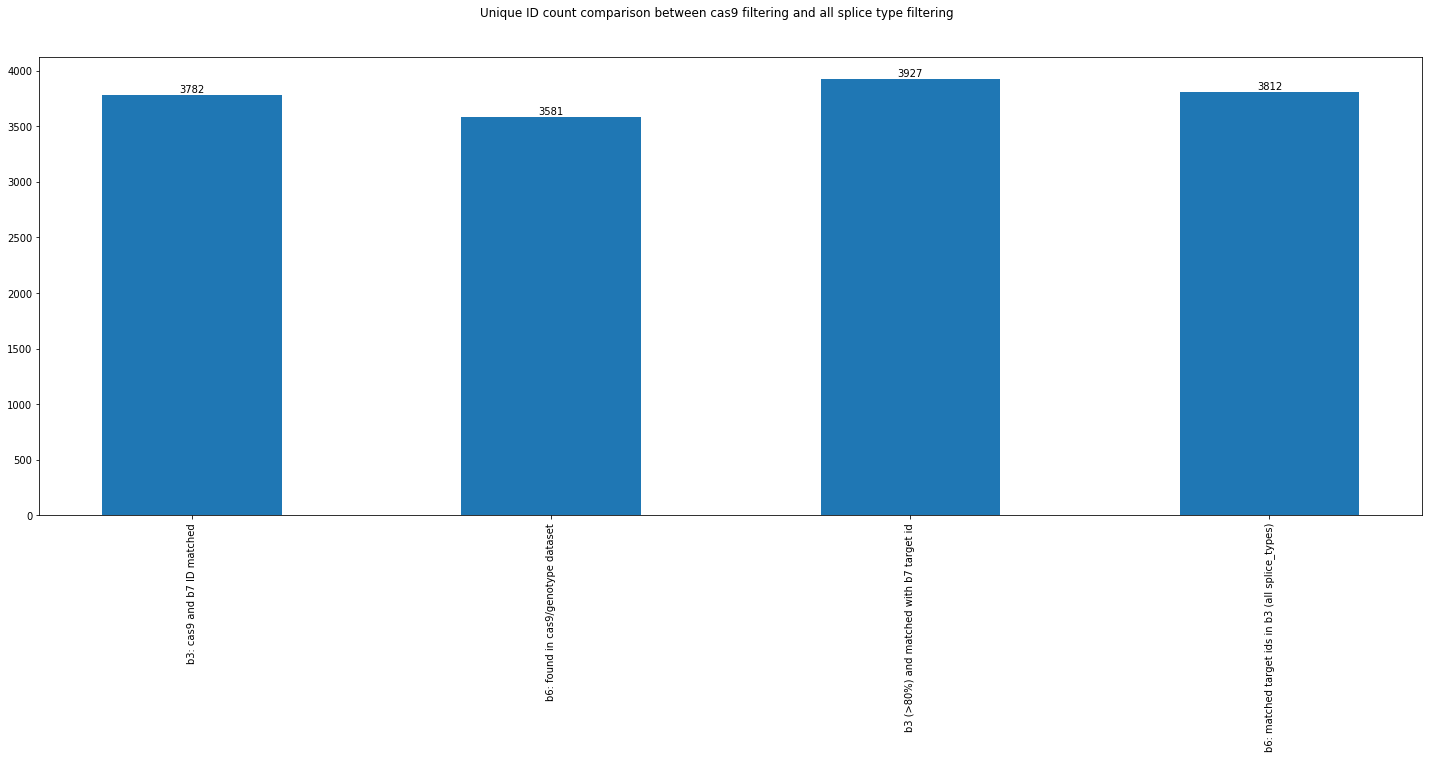

In [65]:
height = [genotype_match.b7_id.nunique(), b6_genotype_match.real_id.nunique(), b3_match.b7_id.nunique(), b6_match_all.real_id.nunique()]
x = [1,2,3,4]
f = plt.figure()
f.set_size_inches(20,10)
f.suptitle('Unique ID count comparison between cas9 filtering and all splice type filtering', y = 1.05)
plot = plt.bar(x, height, width=0.5)
plt.xticks([1,2,3,4], ['b3: cas9 and b7 ID matched',
               'b6: found in cas9/genotype dataset',
               'b3 (>80%) and matched with b7 target id',
               'b6: matched target ids in b3 (all splice_types)'], rotation = 90)

rects = plot.patches

for rect, label in zip(rects, height):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.tight_layout()